# Explore here

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cargar datos
df = pd.read_csv("/workspaces/time_series_project/data/raw/Aquifer_Auser.csv", parse_dates=["Date"], index_col="Date")

# Visualizar primeras filas
print(df.head())


            Rainfall_Gallicano  Rainfall_Pontetetto  Rainfall_Monte_Serra  \
Date                                                                        
05/03/1998                 NaN                  NaN                   NaN   
06/03/1998                 NaN                  NaN                   NaN   
07/03/1998                 NaN                  NaN                   NaN   
08/03/1998                 NaN                  NaN                   NaN   
09/03/1998                 NaN                  NaN                   NaN   

            Rainfall_Orentano  Rainfall_Borgo_a_Mozzano  Rainfall_Piaggione  \
Date                                                                          
05/03/1998                NaN                       NaN                 NaN   
06/03/1998                NaN                       NaN                 NaN   
07/03/1998                NaN                       NaN                 NaN   
08/03/1998                NaN                       NaN          

In [68]:
# Comprobar tipos de datos y valores nulos
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8154 entries, 1998-03-05 to 2020-06-30
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Rainfall_Gallicano                       5295 non-null   float64
 1   Rainfall_Pontetetto                      5295 non-null   float64
 2   Rainfall_Monte_Serra                     5295 non-null   float64
 3   Rainfall_Orentano                        5295 non-null   float64
 4   Rainfall_Borgo_a_Mozzano                 5295 non-null   float64
 5   Rainfall_Piaggione                       5295 non-null   float64
 6   Rainfall_Calavorno                       5295 non-null   float64
 7   Rainfall_Croce_Arcana                    5295 non-null   float64
 8   Rainfall_Tereglio_Coreglia_Antelminelli  5295 non-null   float64
 9   Rainfall_Fabbriche_di_Vallico            5295 non-null   float64
 10  Depth_to_Groundwater_LT2      

In [69]:
df.interpolate(method="spline", order=3, inplace=True)

In [70]:
print(df.isnull().sum())

Rainfall_Gallicano                         2859
Rainfall_Pontetetto                        2859
Rainfall_Monte_Serra                       2859
Rainfall_Orentano                          2859
Rainfall_Borgo_a_Mozzano                   2859
Rainfall_Piaggione                         2859
Rainfall_Calavorno                         2859
Rainfall_Croce_Arcana                      2859
Rainfall_Tereglio_Coreglia_Antelminelli    2859
Rainfall_Fabbriche_di_Vallico              2859
Depth_to_Groundwater_LT2                   2859
Depth_to_Groundwater_SAL                   3319
Depth_to_Groundwater_PAG                   3955
Depth_to_Groundwater_CoS                   3038
Depth_to_Groundwater_DIEC                  4686
Temperature_Orentano                          0
Temperature_Monte_Serra                       0
Temperature_Ponte_a_Moriano                   0
Temperature_Lucca_Orto_Botanico               0
Volume_POL                                 2494
Volume_CC1                              

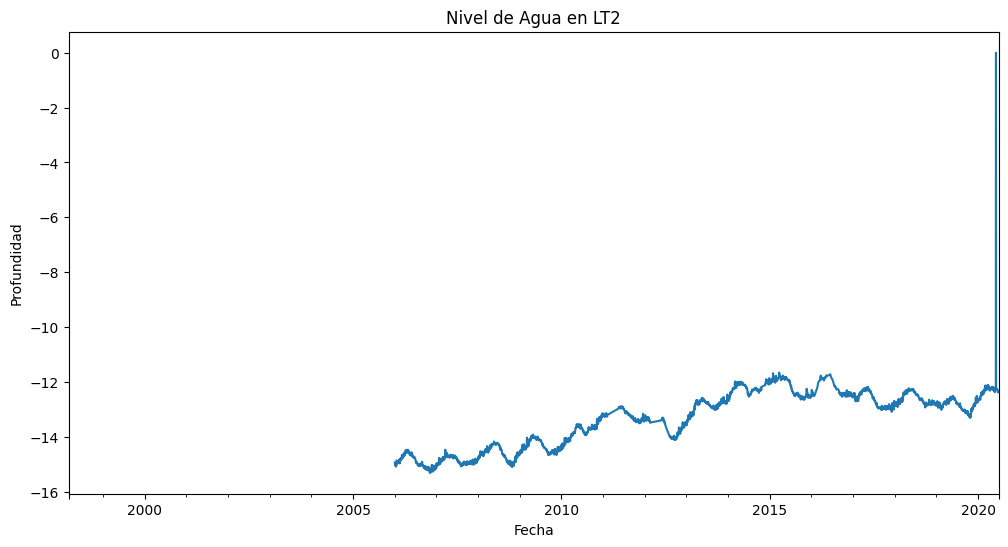

In [71]:
# Visualización de series temporales
plt.figure(figsize=(12, 6))
df["Depth_to_Groundwater_LT2"].plot(title="Nivel de Agua en LT2")
plt.xlabel("Fecha")
plt.ylabel("Profundidad")
plt.show()

In [72]:
# Normalización de datos (Min-Max Scaling)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Crear variables rezagadas (lags) para el modelo
for lag in range(1, 8):  # Lags de 1 hasta 7 días
    df_scaled[f"Depth_Lag_{lag}"] = df_scaled["Depth_to_Groundwater_LT2"].shift(lag)

# Remover filas con valores NaN por los lags
df_scaled.dropna(inplace=True)

print(df_scaled.head())

            Rainfall_Gallicano  Rainfall_Pontetetto  Rainfall_Monte_Serra  \
Date                                                                        
2011-01-02            0.000000             0.000000              0.000000   
2011-01-03            0.000000             0.000000              0.000000   
2011-01-04            0.000627             0.000000              0.000000   
2011-01-05            0.000000             0.000000              0.000000   
2011-01-06            0.005646             0.006821              0.063075   

            Rainfall_Orentano  Rainfall_Borgo_a_Mozzano  Rainfall_Piaggione  \
Date                                                                          
2011-01-02           0.003676                   0.00000            0.000000   
2011-01-03           0.000000                   0.00000            0.000000   
2011-01-04           0.000000                   0.00000            0.000000   
2011-01-05           0.000000                   0.00000          

p-valor: 0.6449816838380708


/workspaces/time_series_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/time_series_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/time_series_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


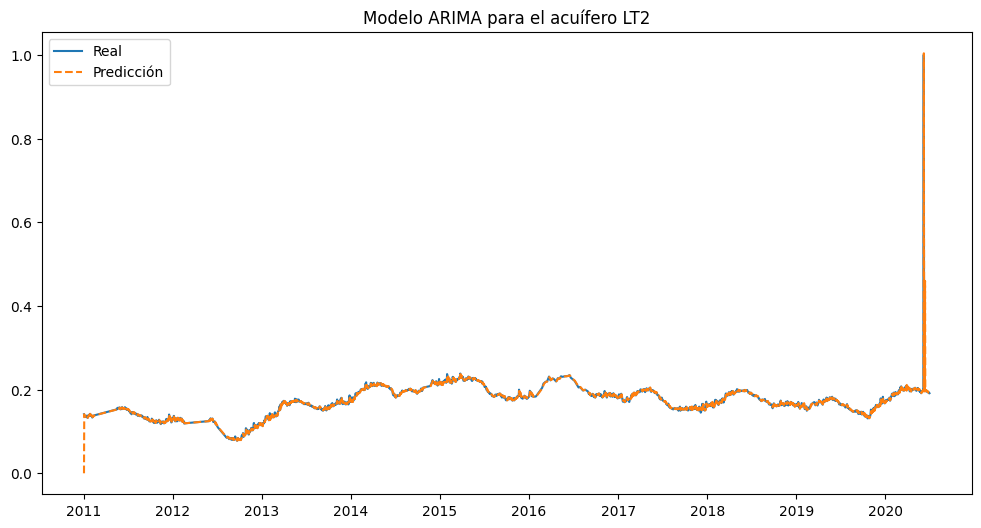

In [73]:
!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Prueba de estacionariedad (Dickey-Fuller)
result = adfuller(df_scaled["Depth_to_Groundwater_LT2"])
print("p-valor:", result[1])  # Si p < 0.05, la serie es estacionaria

# Diferenciación si es necesario
df_scaled["Depth_Diff"] = df_scaled["Depth_to_Groundwater_LT2"].diff().dropna()

# Ajuste de modelo ARIMA
model = ARIMA(df_scaled["Depth_to_Groundwater_LT2"], order=(5,1,0)) # (p,d,q) ajustable
model_fit = model.fit()

# Predicción
df_scaled["Predicción_ARIMA"] = model_fit.predict(start=0, end=len(df_scaled)-1, dynamic=False)

# Visualización
plt.figure(figsize=(12,6))
plt.plot(df_scaled["Depth_to_Groundwater_LT2"], label="Real")
plt.plot(df_scaled["Predicción_ARIMA"], label="Predicción", linestyle="dashed")
plt.legend()
plt.title("Modelo ARIMA para el acuífero LT2")
plt.show()

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Comparar predicciones con valores reales
mae = mean_absolute_error(df_scaled["Depth_to_Groundwater_LT2"], df_scaled["Predicción_ARIMA"])
rmse = np.sqrt(mean_squared_error(df_scaled["Depth_to_Groundwater_LT2"], df_scaled["Predicción_ARIMA"]))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 0.0020550301918673985
RMSE: 0.0160409379618208
